In [1]:
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from talib import (RSI, BBANDS, MACD,
                   NATR, WILLR, WMA,
                   EMA, SMA, CCI, CMO,
                   MACD, PPO, ROC,
                   ADOSC, ADX, MOM, MA, STOCHF)

# pakage for study
from utils import *

In [2]:
all_profit = pd.DataFrame(columns=["profit", "std"])
profit_dict = {}

# Trading

## Proposed Model

In [3]:
train_n=18

In [4]:
prices = pd.read_csv("data/kospi200 futures(30)_20211230.txt", sep='\t', header=None)
prices.columns = ["date", "time", "open", "high", "low", "close", "volume"]

prices.date = pd.to_datetime(prices.date, format='%Y%m%d')
prices = prices.set_index(['date','time'])

In [5]:
def compute_bb(close, timeperiod):
    high, mid, low = BBANDS(close, timeperiod=timeperiod)
    return pd.DataFrame({f'{timeperiod:02}_BBH': high, f'{timeperiod:02}_BBL': low}, index=close.index)

ta_data = pd.read_csv("data/1.kospi200futures_TI.csv", parse_dates=['date'], index_col=["date","time"])
feature_list = [x.split('_')[-1] for x in ta_data.columns[:16]]
ta_data = ta_data.drop(columns=['close','1_updown','5_updown','21_updown'])

T = [int(x.split('_')[0]) for x in ta_data.columns[:16]]

for t in T:
    bbh, bbl = f'{t:02}_BBH', f'{t:02}_BBL'
    bb = compute_bb(prices.close.copy(), timeperiod=t)
    ta_data[bbh] = bb[bbh]
    ta_data[bbl] = bb[bbl]

for t in T:
    ta_data[f'{t:02}_MA'] = MA(prices.close.copy(), timeperiod=t)

for t in T:
    ta_data[f'{t:02}_WMA'] = WMA(prices.close.copy(), timeperiod=t)

for t in T:
    ta_data[f'{t:02}_EMA'] = EMA(prices.close.copy(), timeperiod=t)

for t in T:
    ta_data[f'{t:02}_MACD'] = MACD(prices.close.copy(), signalperiod=t)[0]

In [6]:
test_size = 14

ta_df = pd.DataFrame(columns=['train_n','buy_ta', 'sell_ta', 'count'])

importance_0 = pd.read_csv(f"importance/importance_0.csv", index_col=0, parse_dates=[0])
importance_1 = pd.read_csv(f"importance/importance_1.csv", index_col=0, parse_dates=[0])

return_cols = importance_0.filter(regex='RETURN').columns

importance_0 = importance_0[importance_0.columns.difference(return_cols)]
importance_1 = importance_1[importance_1.columns.difference(return_cols)]

ta_df['buy_ta'] = importance_0.drop(columns=['count']).idxmax(axis=1)
ta_df.loc[importance_0[importance_0.drop(columns=['count']).sum(axis=1) == 0].index, 'buy_ta'] = "Zero"

ta_df['sell_ta'] = importance_1.drop(columns=['count']).idxmax(axis=1)
ta_df.loc[importance_1[importance_1.drop(columns=['count']).sum(axis=1) == 0].index, 'sell_ta'] = "Zero"

ta_df['count'] = importance_0['count']

data = pd.concat([prices['close'], ta_data], axis=1).copy()
data['next_open'] = prices['open'].shift(-1)

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]
    print(f"{count}/{len(ta_df)} {test_data.index[0][0].strftime('%Y-%m-%d')} ~ {test_data.index[-1][0].strftime('%Y-%m-%d')}")
    print(f"Buy : {buy_ta} Sell : {sell_ta}")
    print("")

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100
    ta_df.loc[ta.index, 'BAH'] = ((test_data.close.iloc[-1] - test_data.close.iloc[0]) / test_data.close.iloc[0]) * 100
    ta_df.loc[ta.index, 'train_n'] = f"{train_n}"
    print(f"profit -> {profit*100:.2f}")
    print(f"BAH -> {((test_data.close.iloc[-1] - test_data.close.iloc[0]) / test_data.close.iloc[0]) * 100:.2f}")
    print("---------------------------------")

1/26 2021-01-04 ~ 2021-01-15
Buy : 28_BBL Sell : 52_ADOSC

2021-01-04 1100 Long 진입 394.75
2021-01-15 Long 포지션 청산 394.75->419.85 profit : 6.36%

profit -> 6.36
BAH -> 7.89
---------------------------------
2/26 2021-01-18 ~ 2021-01-29
Buy : 52_ADOSC Sell : 52_BBL

2021-01-18 930 Short 진입 416.95
2021-01-29 Short 포지션 청산 416.95->403.9 profit : 3.13%

profit -> 3.13
BAH -> -3.70
---------------------------------
3/26 2021-02-01 ~ 2021-02-10
Buy : 07_BBL Sell : 31_MACD

2021-02-02 930 Long 진입 417.7
2021-02-04 1200 Long 청산 417.7->418.65 profit : 0.23%
2021-02-05 930 Long 진입 421.8
2021-02-09 900 Long 청산 421.8->421.0 profit : -0.19%
2021-02-09 1400 Short 진입 419.7
2021-02-10 Short 포지션 청산 419.7->420.15 profit : -0.11%

profit -> -0.07
BAH -> 3.88
---------------------------------
4/26 2021-02-15 ~ 2021-02-26
Buy : 07_BBL Sell : 22_MOM

2021-02-15 930 Long 진입 427.55
2021-02-16 1330 Long 청산 427.55->427.05 profit : -0.12%
2021-02-17 930 Short 진입 423.8
2021-02-25 1230 Short 청산 423.8->418.15 profit : 

In [7]:
all_profit.loc["BAH",:] = ta_df.BAH.mean(), ta_df.BAH.std(ddof=0)
all_profit.loc["proposed",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

In [8]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126


In [9]:
# BAH profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['BAH'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["BAH"] = temp_list

# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["proposed"] = temp_list

## MA(10)

In [10]:
ta_df.loc[:,'buy_ta'] = "10_MA"
ta_df.loc[:,'sell_ta'] = "10_MA"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["10_MA",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-05 930 Short 진입 399.1
2021-01-05 1200 Short 청산 399.1->399.8 profit : -0.18%
2021-01-05 1300 Short 진입 398.65
2021-01-05 1430 Short 청산 398.65->399.9 profit : -0.31%
2021-01-06 1200 Short 진입 404.65
2021-01-06 1330 Short 청산 404.65->405.85 profit : -0.30%
2021-01-06 1400 Short 진입 405.35
2021-01-06 1430 Short 청산 405.35->406.8 profit : -0.36%
2021-01-06 1500 Short 진입 403.3
2021-01-07 930 Short 청산 403.3->407.45 profit : -1.03%
2021-01-07 1530 Short 진입 411.25
2021-01-08 930 Short 청산 411.25->419.15 profit : -1.92%
2021-01-11 1230 Short 진입 432.25
2021-01-12 900 Short 청산 432.25->428.3 profit : 0.91%
2021-01-12 930 Short 진입 425.75
2021-01-12 1530 Short 청산 425.75->427.45 profit : -0.40%
2021-01-14 900 Short 진입 427.1
2021-01-14 930 Short 청산 427.1->430.35 profit : -0.76%
2021-01-14 1000 Short 진입 429.6
2021-01-14 1200 Short 청산 429.6->430.2 profit : -0.14%
2021-01-14 1330 Short 진입 428.55
2021-01-14 1500 Short 청산 428.55->429.8 profit : -0.29%
2021-01-15 1000 Short 진입 427.1
2021-01-15 Short 포지션 청산

In [11]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009


In [12]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["10_MA"] = temp_list

## 07_BBL

In [13]:
ta_df.loc[:,'buy_ta'] = "07_BBL"
ta_df.loc[:,'sell_ta'] = "07_BBL"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["07_BBL",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-04 1100 Long 진입 394.75
2021-01-05 1030 Long 청산 394.75->397.95 profit : 0.81%
2021-01-05 1500 Long 진입 403.3
2021-01-12 1300 Long 청산 403.3->420.7 profit : 4.31%
2021-01-14 1330 Short 진입 428.55
2021-01-15 Short 포지션 청산 428.55->419.85 profit : 2.03%

2021-01-18 930 Short 진입 416.95
2021-01-21 1530 Short 청산 416.95->429.85 profit : -3.09%
2021-01-22 1100 Long 진입 432.7
2021-01-26 930 Long 청산 432.7->433.25 profit : 0.13%
2021-01-27 930 Long 진입 426.8
2021-01-28 930 Long 청산 426.8->412.35 profit : -3.39%

2021-02-02 930 Long 진입 417.7
2021-02-04 1000 Long 청산 417.7->417.6 profit : -0.02%
2021-02-05 930 Long 진입 421.8
2021-02-10 Long 포지션 청산 421.8->420.15 profit : -0.39%

2021-02-15 930 Long 진입 427.55
2021-02-17 930 Long 청산 427.55->423.8 profit : -0.88%
2021-02-18 1100 Short 진입 420.3
2021-02-25 1230 Short 청산 420.3->418.15 profit : 0.51%
2021-02-26 930 Short 진입 410.15
2021-02-26 Short 포지션 청산 410.15->409.7 profit : 0.11%

2021-03-02 930 Long 진입 421.15
2021-03-05 930 Long 청산 421.15->407.55 profit :

In [14]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009
07_BBL,-0.002144,2.398284


In [15]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["07_BBL"] = temp_list

## 07_BBL-Zero

In [16]:
ta_df.loc[:,'buy_ta'] = "07_BBL"
ta_df.loc[:,'sell_ta'] = "Zero"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["07_BBL-Zero",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-04 1100 Long 진입 394.75
2021-01-15 Long 포지션 청산 394.75->419.85 profit : 6.36%

2021-01-21 1530 Long 진입 429.85
2021-01-29 Long 포지션 청산 429.85->403.9 profit : -6.04%

2021-02-02 930 Long 진입 417.7
2021-02-10 Long 포지션 청산 417.7->420.15 profit : 0.59%

2021-02-15 930 Long 진입 427.55
2021-02-26 Long 포지션 청산 427.55->409.7 profit : -4.17%

2021-03-02 930 Long 진입 421.15
2021-03-12 Long 포지션 청산 421.15->415.15 profit : -1.42%

2021-03-17 1500 Long 진입 413.45
2021-03-26 Long 포지션 청산 413.45->411.95 profit : -0.36%

2021-03-30 930 Long 진입 414.65
2021-04-09 Long 포지션 청산 414.65->423.4 profit : 2.11%

2021-04-13 930 Long 진입 425.9
2021-04-23 Long 포지션 청산 425.9->427.0 profit : 0.26%

2021-04-26 1000 Long 진입 428.65
2021-05-07 Long 포지션 청산 428.65->428.5 profit : -0.03%

2021-05-10 1000 Long 진입 431.4
2021-05-21 Long 포지션 청산 431.4->421.65 profit : -2.26%

2021-05-25 1000 Long 진입 423.4
2021-06-04 Long 포지션 청산 423.4->432.3 profit : 2.10%

2021-06-10 1330 Long 진입 430.8
2021-06-18 Long 포지션 청산 430.8->434.45 profit : 0.

In [17]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009
07_BBL,-0.002144,2.398284
07_BBL-Zero,-0.534978,2.546873


In [18]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["07_BBL-Zero"] = temp_list

## 07_BBL-22_BBL

In [19]:
ta_df.loc[:,'buy_ta'] = "07_BBL"
ta_df.loc[:,'sell_ta'] = "22_BBL"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["07_BBL-22_BBL",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-04 1100 Long 진입 394.75
2021-01-15 1000 Long 청산 394.75->427.1 profit : 8.20%

2021-01-18 1430 Short 진입 410.0
2021-01-21 1530 Short 청산 410.0->429.85 profit : -4.84%
2021-01-22 1100 Long 진입 432.7
2021-01-28 930 Long 청산 432.7->412.35 profit : -4.70%
2021-01-29 1300 Short 진입 409.75
2021-01-29 Short 포지션 청산 409.75->403.9 profit : 1.43%

2021-02-02 930 Long 진입 417.7
2021-02-04 1000 Long 청산 417.7->417.6 profit : -0.02%
2021-02-04 1230 Short 진입 416.2
2021-02-05 930 Short 청산 416.2->421.8 profit : -1.35%
2021-02-05 1500 Long 진입 422.6
2021-02-09 1530 Long 청산 422.6->417.35 profit : -1.24%
2021-02-10 1030 Short 진입 415.0
2021-02-10 Short 포지션 청산 415.0->420.15 profit : -1.24%

2021-02-15 930 Long 진입 427.55
2021-02-17 930 Long 청산 427.55->423.8 profit : -0.88%
2021-02-18 1300 Short 진입 418.05
2021-02-25 1230 Short 청산 418.05->418.15 profit : -0.02%

2021-03-02 930 Long 진입 421.15
2021-03-05 930 Long 청산 421.15->407.55 profit : -3.23%
2021-03-09 930 Short 진입 405.2
2021-03-11 930 Short 청산 405.2->407.25 

In [20]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009
07_BBL,-0.002144,2.398284
07_BBL-Zero,-0.534978,2.546873
07_BBL-22_BBL,-0.562024,3.098517


In [21]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["07_BBL-22_BBL"] = temp_list

## 07_BBL-19_BBL

In [22]:
ta_df.loc[:,'buy_ta'] = "07_BBL"
ta_df.loc[:,'sell_ta'] = "19_BBL"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["07_BBL-19_BBL",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-04 1100 Long 진입 394.75
2021-01-12 1300 Long 청산 394.75->420.7 profit : 6.57%
2021-01-14 1430 Short 진입 428.1
2021-01-15 Short 포지션 청산 428.1->419.85 profit : 1.93%

2021-01-18 1330 Short 진입 412.55
2021-01-21 1530 Short 청산 412.55->429.85 profit : -4.19%
2021-01-22 1100 Long 진입 432.7
2021-01-26 1130 Long 청산 432.7->427.15 profit : -1.28%
2021-01-27 930 Long 진입 426.8
2021-01-28 930 Long 청산 426.8->412.35 profit : -3.39%
2021-01-29 1230 Short 진입 410.1
2021-01-29 Short 포지션 청산 410.1->403.9 profit : 1.51%

2021-02-02 930 Long 진입 417.7
2021-02-04 1000 Long 청산 417.7->417.6 profit : -0.02%
2021-02-04 1230 Short 진입 416.2
2021-02-05 930 Short 청산 416.2->421.8 profit : -1.35%
2021-02-05 1500 Long 진입 422.6
2021-02-10 1030 Long 청산 422.6->415.0 profit : -1.80%

2021-02-15 930 Long 진입 427.55
2021-02-17 930 Long 청산 427.55->423.8 profit : -0.88%
2021-02-18 1230 Short 진입 419.05
2021-02-25 1230 Short 청산 419.05->418.15 profit : 0.21%

2021-03-02 930 Long 진입 421.15
2021-03-05 930 Long 청산 421.15->407.55 prof

In [23]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009
07_BBL,-0.002144,2.398284
07_BBL-Zero,-0.534978,2.546873
07_BBL-22_BBL,-0.562024,3.098517
07_BBL-19_BBL,-0.489253,3.000949


In [24]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["07_BBL-19_BBL"] = temp_list

## 07_BBL-52_BBL

In [25]:
ta_df.loc[:,'buy_ta'] = "07_BBL"
ta_df.loc[:,'sell_ta'] = "52_BBL"

for count in ta_df['count'].values:
    ta = ta_df[ta_df['count'] == count]

    test_start = ta.index[0]
    test_end = test_start + datetime.timedelta(days=test_size-1)

    test_data = data.loc[test_start:test_end]

    buy_ta = ta.buy_ta.values[0]
    sell_ta = ta.sell_ta.values[0]

    profit = trade(test_data, ta.buy_ta.values[0], ta.sell_ta.values[0])
    print("")

    ta_df.loc[ta.index, 'profit'] = profit * 100

all_profit.loc["07_BBL-52_BBL",:] = ta_df.profit.mean(), ta_df.profit.std(ddof=0)

2021-01-04 1100 Long 진입 394.75
2021-01-15 Long 포지션 청산 394.75->419.85 profit : 6.36%

2021-01-18 930 Short 진입 416.95
2021-01-21 1530 Short 청산 416.95->429.85 profit : -3.09%
2021-01-22 1100 Long 진입 432.7
2021-01-28 930 Long 청산 432.7->412.35 profit : -4.70%
2021-01-28 1330 Short 진입 413.5
2021-01-29 Short 포지션 청산 413.5->403.9 profit : 2.32%

2021-02-02 930 Long 진입 417.7
2021-02-10 1030 Long 청산 417.7->415.0 profit : -0.65%

2021-02-15 930 Long 진입 427.55
2021-02-18 1300 Long 청산 427.55->418.05 profit : -2.22%
2021-02-18 1530 Short 진입 416.8
2021-02-25 1230 Short 청산 416.8->418.15 profit : -0.32%

2021-03-02 930 Long 진입 421.15
2021-03-09 930 Long 청산 421.15->405.2 profit : -3.79%
2021-03-11 930 Long 진입 407.25
2021-03-12 Long 포지션 청산 407.25->415.15 profit : 1.94%

2021-03-17 1230 Short 진입 411.05
2021-03-17 1500 Short 청산 411.05->413.45 profit : -0.58%
2021-03-18 930 Long 진입 419.05
2021-03-24 930 Long 청산 419.05->404.75 profit : -3.41%
2021-03-24 1130 Short 진입 405.5
2021-03-25 900 Short 청산 405.5->405.7

In [26]:
all_profit

,profit,std
BAH,0.20527,2.590938
proposed,0.616063,1.755126
10_MA,0.175392,1.592009
07_BBL,-0.002144,2.398284
07_BBL-Zero,-0.534978,2.546873
07_BBL-22_BBL,-0.562024,3.098517
07_BBL-19_BBL,-0.489253,3.000949
07_BBL-52_BBL,-0.468223,2.692092


In [27]:
# proposed model profit
money = 100

temp_list = []
for i in range(len(ta_df)):
    money *= (1 + ta_df['profit'].iloc[i]/100)
    temp_list.append(money)
    
profit_dict["07_BBL-52_BBL"] = temp_list

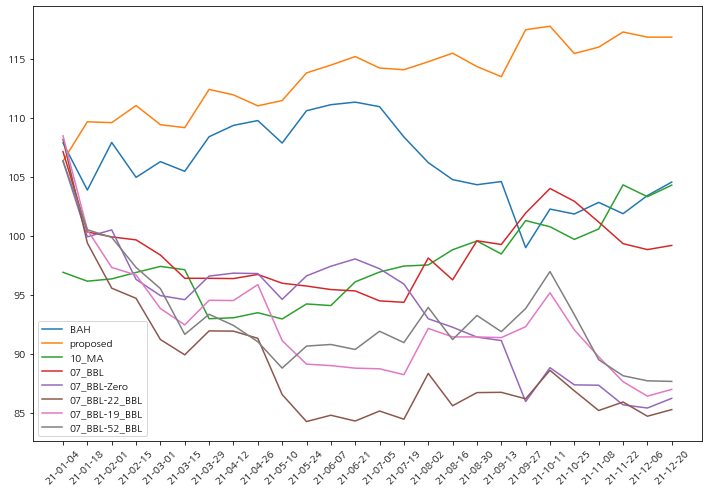

In [28]:
plt.figure(figsize=(12,8))
for key, profits in profit_dict.items():
    plt.plot(list(ta_df.index.strftime("%y-%m-%d")), profits, label=key)
    plt.xticks(rotation=45)
    plt.legend()
plt.show()